## PART 03: TELCO CUSTOMER CHURN ANALYSIS

#### Author: GREJELL B. SEGURA
#### Date: August 04, 2020

#### NOTE:  
##### This notebook is the continuation of the Churn Analysis. This covers the feature engineering.

## Contents

* [1.  Scaling (Standardization)](#scale)    
* [2.  Principal Component Analysis](#pca)
* [3.  Clustering by K-means](#kmeans)
* [4.  Binning/Bucketing](#bucket)

In [125]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split


# VISUALIZATION
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# PCA
from sklearn.decomposition import PCA

# SCALING
from sklearn import preprocessing

# KMEANS
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [69]:
os.chdir(r'C:/Users/gbsegura/Documents/AMPD-Projects/archive/xxx-bank-test-churn-analysis')
X_train = pd.read_pickle('./data/X_train.pkl')
Y_train = pd.read_pickle('./data/Y_train.pkl')
x_test = pd.read_pickle('./data/x_test.pkl')
y_test = pd.read_pickle('./data/y_test.pkl')
cleanData = pd.read_pickle('./data/cleanData.pkl')
cleanData.rename({'Churn_Yes':'target'}, axis=1, inplace=True)

<a id="scale"></a>
## 1. Scaling (Standardization)

A very common feature engineering or sometimes a pre-processing procedure is the scaling of the numerical features.  
It converts the data into a standardized data where the mean is 0 and standard deviation is 1.  
The data points are calculated as to how much standard deviation it is from the mean.  
It is a very essential step to train a machine learning model that relies on distances/similarities between features.

In [3]:
newData = cleanData

scaler = preprocessing.StandardScaler().fit(cleanData[['tenure']].to_numpy())
tenure = scaler.transform(cleanData[['tenure']].to_numpy())

scaler = preprocessing.StandardScaler().fit(cleanData[['TotalCharges']].to_numpy())
TotalCharges = scaler.transform(cleanData[['TotalCharges']].to_numpy())

scaler = preprocessing.StandardScaler().fit(cleanData[['MonthlyCharges']].to_numpy())
MonthlyCharges = scaler.transform(cleanData[['MonthlyCharges']].to_numpy())

newData['tenure'] = tenure
newData['TotalCharges'] = TotalCharges
newData['MonthlyCharges'] = MonthlyCharges

newData[['MonthlyCharges', 'TotalCharges', 'tenure']].describe()

,MonthlyCharges,TotalCharges,tenure
count,7.032000e+03,7.032000e+03,7.032000e+03
mean,9.652878e-17,-1.172113e-16,-1.214741e-16
std,1.000071e+00,1.000071e+00,1.000071e+00
min,-1.547283e+00,-9.990692e-01,-1.280248e+00
25%,-9.709769e-01,-8.302488e-01,-9.542963e-01
50%,1.845440e-01,-3.908151e-01,-1.394171e-01
75%,8.331482e-01,6.668271e-01,9.199259e-01
max,1.793381e+00,2.824261e+00,1.612573e+00


The numerical features have been scaled by standardization. Evidence of this is that the mean is now 0 and the standard deviation is 1.

<a id="pca"></a>
## 2. Principal Component Analysis

This algorithm is commonly used for a dimension reduction purposes.  
However, the results of this can also be used a feature to improve the machine learning models.  
  
  
PCA projects the data in the lower dimension in a way that it has highest variances in its axes which are the principal components.

In [4]:
pcaData = newData[['tenure', 'MonthlyCharges', 'TotalCharges']]
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pcaData)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

In [11]:
principalDf['target'] = newData['target']

In [6]:
principalDf.columns

Index(['pc1', 'pc2', 'Churn'], dtype='object')

In [61]:
def plot_pair(data, x_feature, y_feature, hue=None, marker=None, size=None, s=100, style=None, title=None):
    sns.set(rc={'figure.figsize':(12,8.27)})
    five_thirty_eight = [
                        "#30a2da",
                        "#fc4f30",
                        "#e5ae38",
                        "#6d904f",
                        "#8b8b8b",
                        ]
    sns.set_palette(five_thirty_eight)
    sns.set(font_scale = 1.5)
    scatter = sns.scatterplot(x=x_feature, y=y_feature, data=data, hue=hue, marker=marker, size=size, s=s, style=style, alpha=0.7)
    scatter.axes.set_title(title,fontsize=20)
    scatter.plot()

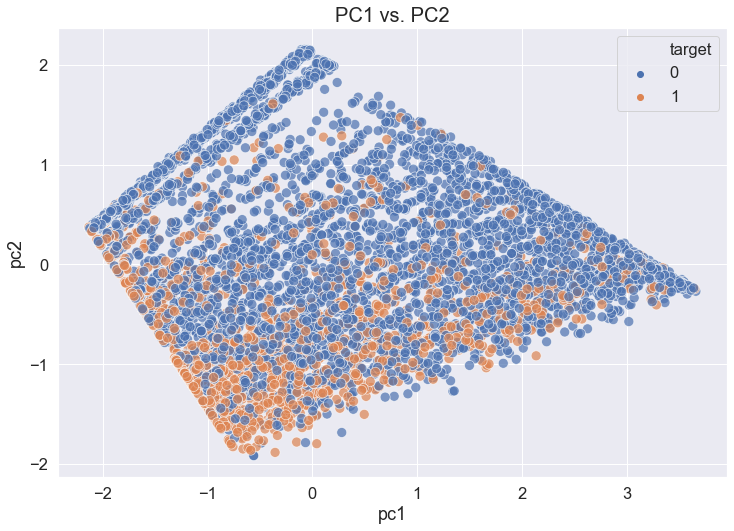

In [53]:
plot_pair(principalDf, x_feature='pc1', y_feature='pc2', hue='target', title='PC1 vs. PC2')

In [14]:
newData['pc1'] = principalDf['pc1']
newData['pc2'] = principalDf['pc2']

<a id="kmeans"></a>
## 3. Clustering by K-means

Kmeans clustering is another machine learning model that generates a cluster by training on an unsupervised data.  
The results can be used as an additional feature to improve supervised machine learning models.

Let us first examine and identify the optimal number of clusters by looking at the Elbow Method chart below.

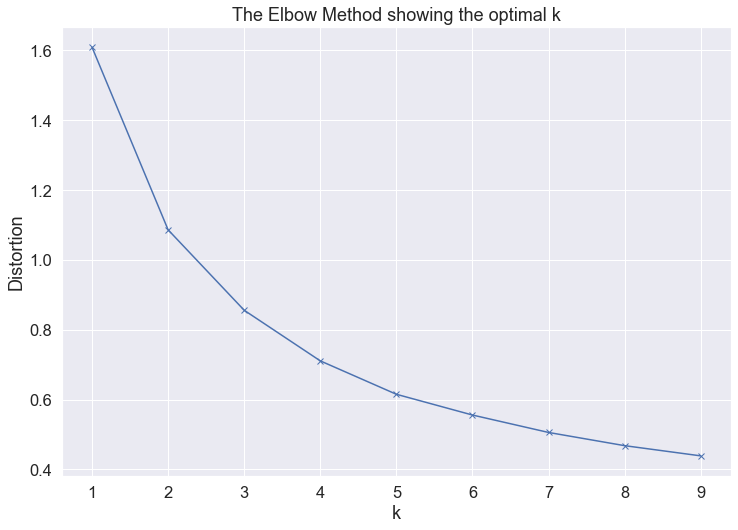

In [24]:
x1 = np.array(newData['tenure'])
x2 = np.array(newData['MonthlyCharges'])
x3 = np.array(newData['TotalCharges'])

# create new plot and data
plt.plot()
X = np.array(list(zip(x1, x2, x3))).reshape(len(x1), 3)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [111]:
k = 5

kmeans = KMeans(
   init="random",
   n_clusters=k,
   n_init=10,
   max_iter=300,
   random_state=23
   )

kmeans.fit(X)

KMeans(init='random', n_clusters=5, random_state=23)

In [112]:
newData['kmeans'] = kmeans.labels_

In [114]:
def plot_categorical(data, feature, rotate=0, y_axis="percentage of customers", title=None):
    plt.figure()
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15, rotation=rotate)
    sns.set(rc={'figure.figsize':(10,7)})
    five_thirty_eight = [
                        "#30a2da",
                        "#fc4f30",
                        "#e5ae38",
                        "#6d904f",
                        "#8b8b8b",
                        ]
    sns.set_palette(five_thirty_eight)

    graph_data = data.groupby(feature)["target"].value_counts().to_frame()
    graph_data = graph_data.rename({"target": y_axis}, axis=1).reset_index()
    graph_data[y_axis] = graph_data[y_axis]/len(data)
    bar = sns.barplot(x=feature, y= y_axis, hue='target', data=graph_data)
#     bar.set_xticklabels(['{:,.0%}'.format(x) for x in bar.get_xticks()])
    bar.set_yticklabels(['{:,.0%}'.format(x) for x in bar.get_yticks()])
    
    for p in bar.patches:
             bar.annotate("%.2f" % (p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=15, xytext=(0, 20),
                 textcoords='offset points')

    bar.axes.set_title(title,fontsize=20)
    bar.set_xlabel("")
    bar.set_ylabel(y_axis, fontsize=18)
    bar.plot()

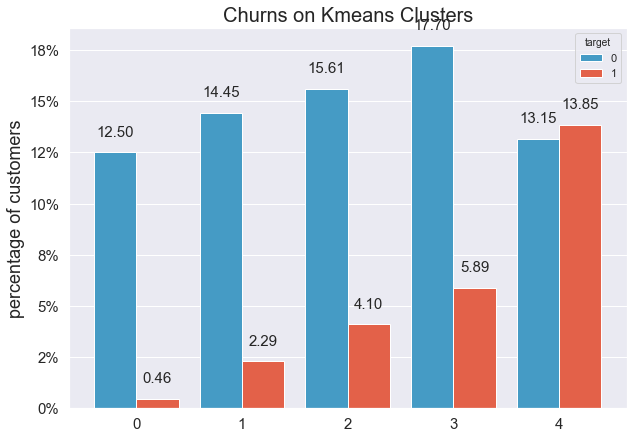

In [115]:
plot_categorical(newData, 'kmeans', title='Churns on Kmeans Clusters')

A visible separation can be observed between clusters 0 to 3 against cluster 4.  
Cluster 4 is the only cluster where the unsubscribed is more than the subscribed.  
For this reason, I rebucketed the clusters to group clusters 0 to 3 as one while cluster 4 remains the same.

In [116]:
newData.loc[newData['kmeans']!=4, 'kmeans'] = 0
newData.loc[newData['kmeans']==4, 'kmeans'] = 1

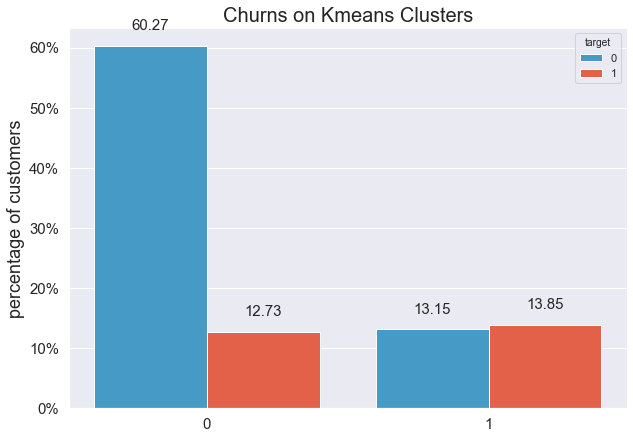

In [117]:
plot_categorical(newData, 'kmeans', title='Churns on Kmeans Clusters')

<a id="bucket"></a>
## 4. Binning/Bucketing (Tenure)

Binning/Bucketing is a common way to group numerical features.  
Here, based on the visualization below, the churns are more when the tenure is below 20 while lesser when tenure is more than 20.  
We have grouped the data based on this fact.

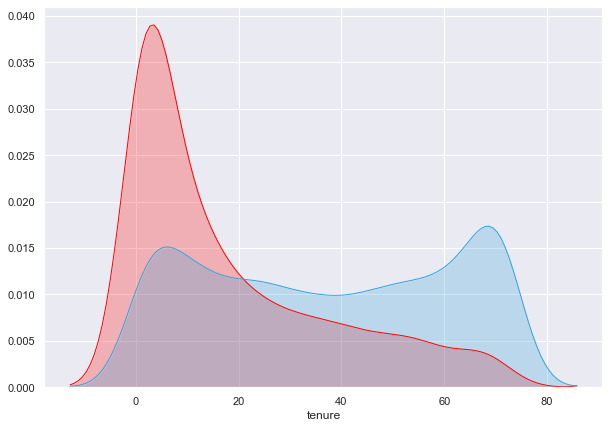

In [118]:
    plot = sns.distplot(cleanData['tenure'][cleanData['target']==1], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 1}, color='red')
    plot = sns.distplot(cleanData['tenure'][cleanData['target']==0], hist = False, kde = True,
                     kde_kws = {'shade': True, 'linewidth': 1})

In [119]:
cleanData.loc[cleanData['tenure']<=20, 'tenure_below20'] = 1
cleanData.loc[cleanData['tenure']>20, 'tenure_below20'] = 0

In [120]:
newData['tenure_below20'] = cleanData['tenure_below20']

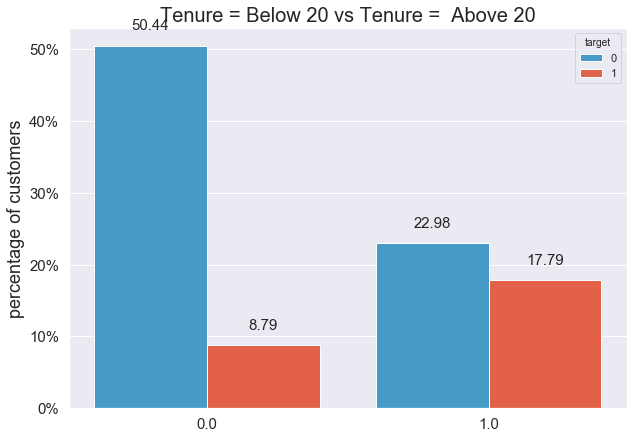

In [131]:
plot_categorical(newData, 'tenure_below20', title='Tenure = Below 20 vs Tenure =  Above 20')

In [126]:
def split_data(data):
    data = data.rename(columns={'Churn_Yes': 'target'})
    dataX = data.drop(['target'], axis = 1)
    dataY = data['target']
    
    # Create train and test dataset
    X_train, x_test, Y_train, y_test = train_test_split(dataX, dataY, random_state = 0)
    return X_train, x_test, Y_train, y_test

new_X_train, new_x_test, new_Y_train, new_y_test = split_data(newData)

In [127]:
newData.to_pickle('./data/newData.pkl')
new_X_train.to_pickle('./data/new_X_train.pkl')
new_x_test.to_pickle('./data/new_x_test.pkl')
new_Y_train.to_pickle('./data/new_Y_train.pkl')
new_y_test.to_pickle('./data/new_y_test.pkl')